In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [2]:
df = pd.read_csv(r'C:\Users\admin\Downloads\nse stock prediction\NSE-TATAGLOBAL11.csv')

df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [3]:
df.shape

(1235, 8)

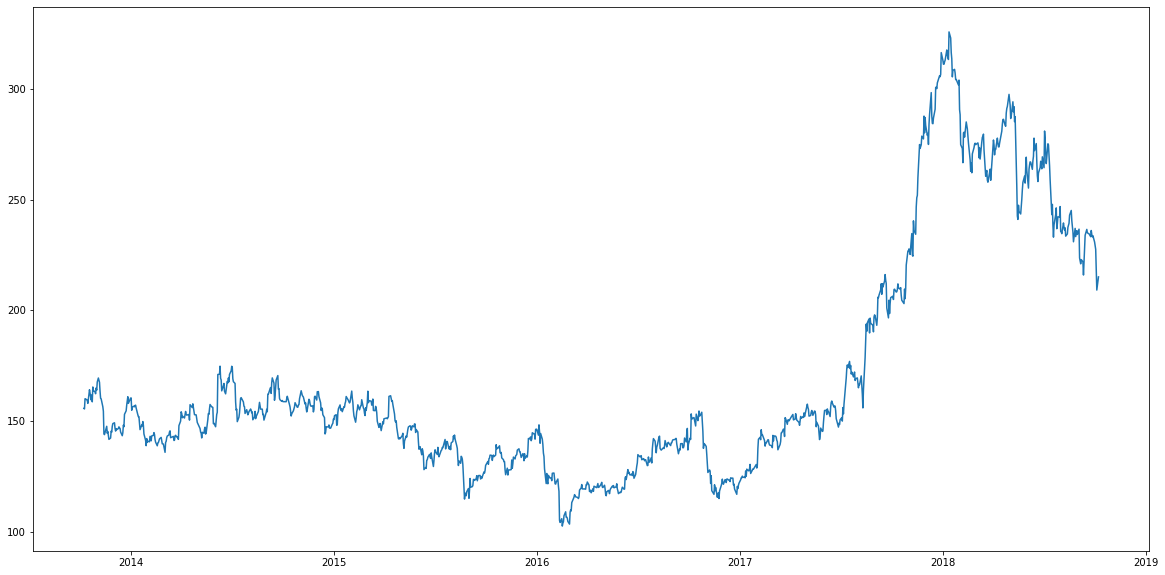

In [4]:
# ploting target variable

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

plt.figure(figsize=(20,10))
plt.plot(df['Close'], label = 'Closing price history')

In [5]:
data = df.sort_index(ascending = True, axis=0)
data_new = pd.DataFrame(index = range(0, len(df)), columns = ['Date', 'Close'])

In [6]:
for i in range(0, len(data)):
    data_new['Date'][i] = data['Date'][i]
    data_new['Close'][i] = data['Close'][i]

In [7]:
train = data_new[:987]
test = data_new[987:]

# Moving Average

In [8]:
print(f'Training set shape : {train.shape}\nTest set shape : {test.shape}')

Training set shape : (987, 2)
Test set shape : (248, 2)


In [9]:
#  create predictions for the testing set and check the RMSE using the actual values.
preds = []
for i in range(0,test.shape[0]):
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

In [10]:
# results RMSE value
rms = np.sqrt(np.mean(np.power((np.array(test['Close']) - preds),2)))
f'Rmse value for test set : {rms}'

'Rmse value for test set : 104.51415465984348'

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


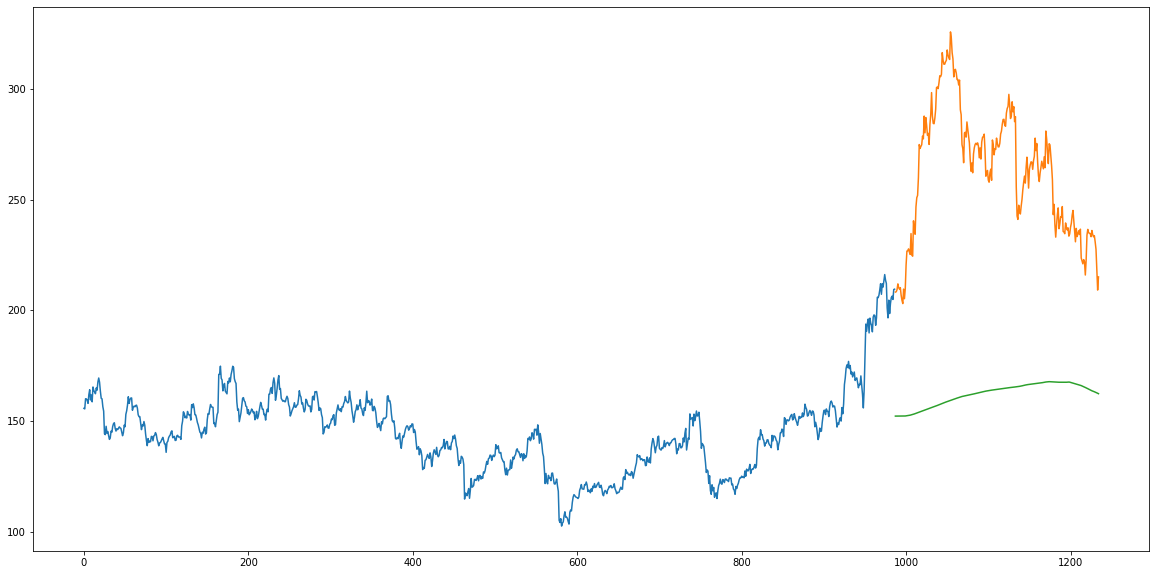

In [11]:
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])

Blue = train;
Orange = test;
Green = Predicted

# LSTM Model

In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [13]:
data = df.sort_index(ascending = True, axis=0)

In [14]:
new_data = pd.DataFrame(index = range(0, len(df)), columns = ['Date', 'Close'])
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [15]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [16]:
dataset = new_data.values

train = dataset[0:987,:]
test = dataset[987:,:]

In [17]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [18]:
x_train, y_train = [], []

for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [21]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [22]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


927/927 - 57s - loss: 0.0011


In [23]:
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [24]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [25]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [26]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
rms

15.176137083172971

c:\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


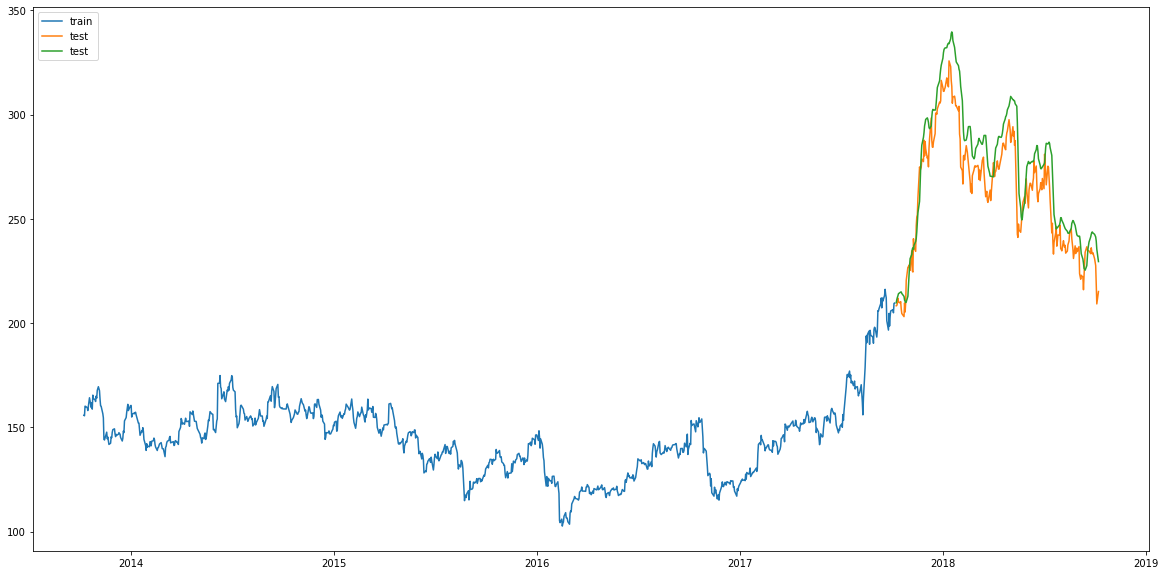

In [30]:
# plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], label = 'train')
plt.plot(valid[['Close','Predictions']], label = 'test')
plt.legend(loc="upper left")
# plt.legend()

Blue = train;
Orange = test;
Green = Predicted